In [6]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
import fiona
import os
import glob
from scipy import sparse
%matplotlib inline

In [198]:
#Identify watershed by three letter acronymn and phase
wshed = "EGM"
phase = "P05"
subbasin= "Arrowsmith"

#raster cell resolution
resolution = 1

name = wshed + "_" + str(phase)
subbasin_name = str(wshed + "_" + str(phase) + "_" + subbasin)
print("sub-basin: " + str(subbasin_name))
print("phase: " + str(phase))

# path to your bare earth, and path to a cleaned snow depth raster
be_dem = r"H:\Englishman\2021\DEMs\bare_earth\EGM_BE_wgs84_1m.tif"
snow_depth = r"H:\Englishman\2021\GIS\SD_clean\\" + name + "_SD_clean.tif"
aspect = r"H:\Englishman\2021\GIS\aspect.tif"

#shapefile is the basin used to mask the rasters, should include the total lidar area if not a sub basin
basin = subbasin + ".shp"
mask_directory = r"H:\Englishman\2021\GIS\boundaries"

#swe table output for matrices
out_swe_tables = r"H:\Englishman\2021\Analysis\swe_tables"

#swe multipliers as a dictionary, with lower CI, water volume, then high CI
swe_multipliers = {"P01" : {"LCI" : .348, "M" : .38, "HCI" : .415}, 
                    "P02" : {"LCI" : .400, "M" : .42, "HCI" : .432}, 
                    "P03" : {"LCI" : .476, "M" : .50, "HCI" : .519},
                    "P04" : {"LCI" : .512, "M" : .53, "HCI" : .547},
                   "P05" : {"LCI" : .554, "M" : .57, "HCI" : .589}}


sub-basin: EGM_P05_Arrowsmith
phase: P05


In [199]:
# isolate the lower CI, higher CI, and swe multipliers
l_multi = swe_multipliers[phase]["LCI"]
h_multi = swe_multipliers[phase]["HCI"]
multiplier = swe_multipliers[phase]["M"]

# Dividing the multipliers to calculate the factor to multiply by

lm = l_multi/multiplier 
um = h_multi/multiplier
print("Phase: " + str(name))
print("low CI: " + str(l_multi), str(lm))
print("high CI: " + str(h_multi), str(um))
print("multiplier: " + str(multiplier))



Phase: EGM_P05
low CI: 0.554 0.9719298245614036
high CI: 0.589 1.0333333333333334
multiplier: 0.57


In [200]:
#extract the cooridnates of the sub basin shapefile 
def coords (mask_directory, basin):
    os.chdir(mask_directory)
    with fiona.open(basin) as shapefile:
        for feature in shapefile:
            shapes = [feature["geometry"]]
    return shapes

In [201]:
#call function - output should be paired coordinates
mask_coords = coords(mask_directory, basin)
display(mask_coords)
type(mask_coords)

[{'type': 'Polygon',
  'coordinates': [[(387057.4536537798, 5453493.23229841),
    (387401.8434505211, 5453476.672143664),
    (387529.44851290435, 5453446.1438609045),
    (387660.57993982267, 5453413.51536452),
    (387811.3929921016, 5453366.641138332),
    (387935.8773352336, 5453253.403311208),
    (388097.47273003496, 5453154.2000101),
    (388269.3044275893, 5453079.433731416),
    (388447.00644058734, 5452998.772474825),
    (388525.1629962418, 5452861.299386334),
    (388584.3619885398, 5452672.8606037665),
    (388545.2371337898, 5452482.778266586),
    (388531.34653958026, 5452269.033849275),
    (388625.80170552805, 5452029.61145124),
    (388467.77100558113, 5451936.201626269),
    (388421.2132661557, 5451781.567932606),
    (388252.77311356645, 5451728.973886151),
    (388052.8676812211, 5451685.814460114),
    (387918.3046238143, 5451742.374239575),
    (387774.0322607504, 5451712.579632727),
    (387635.9566727914, 5451584.358025515),
    (387331.5872750133, 5451611.972

list

In [ ]:
#calculate the aspect grid using the bare earth, and mask by the basin
#comment out if not needed
# def calculate_aspect(DEM, mask_coords):
#     gdal.DEMProcessing('aspect.tif', DEM, 'aspect')
#     with rio.open("aspect.tif") as src:
#         raster_image, raster_transform = rio.mask.mask(src, mask_coords, crop=True)
#         return raster_image

In [ ]:
#check that the plot displays, and shape produces paired coordinates
#This line removes the 1st digit
# aspect = aspect[0,:,:]
# display(aspect)
# display(aspect.shape)
# plt.imshow(aspect)

In [202]:
#call function to mask the 
def open_masked_raster_array(tif):
    with rio.open(tif) as src:
        raster_image, raster_transform = rio.mask.mask(src, mask_coords, crop=True)
        return raster_image

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

(2045, 3245)

CPU times: total: 438 ms
Wall time: 446 ms


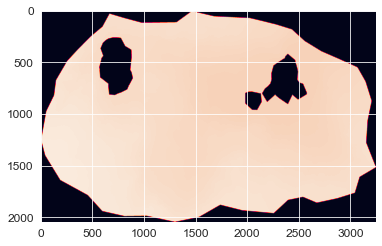

In [203]:
%%time
#mask the bare earth, check it displays
be_dem = open_masked_raster_array(be_dem)
be_dem = be_dem[0,:,:]
#no data value likey -3.40282...
display(be_dem)
display(be_dem.shape)
plt.imshow(be_dem)

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

(2045, 3245)

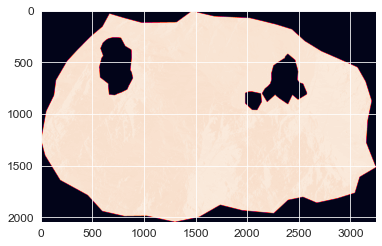

In [204]:
aspect = open_masked_raster_array(aspect)
aspect = aspect[0,:,:]
display(aspect)
display(aspect.shape)
plt.imshow(aspect)

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
        -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]], dtype=float32)

(2045, 3245)

CPU times: total: 156 ms
Wall time: 3.92 s


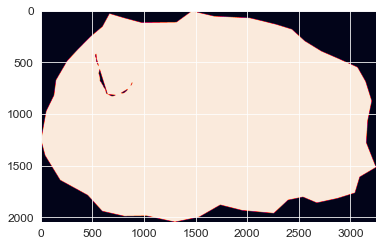

In [205]:
%%time
#mask the snow depth, check it displays
snow_depth = open_masked_raster_array(snow_depth)
snow_depth = snow_depth[0,:,:]
#check the no data value, will be needed for next stage, could be -999
display(snow_depth)
display(snow_depth.shape)
plt.imshow(snow_depth)

In [206]:
#may need to change your no data value for the snow depth raster
no_data_sd = -999
aspect[be_dem < 0] = np.nan
snow_depth[be_dem < 0]= np.nan
be_dem[be_dem < 0] = np.nan
#snow_depth[snow_depth == -999] = 0

In [207]:
#check that the shapes are the same
be_dem.shape == snow_depth.shape


True

In [208]:
be_dem.shape == aspect.shape

True

In [209]:
#unravel the rasters
be_dem_ravel = np.ravel(be_dem)
aspect_ravel = np.ravel(aspect)
snow_depth_ravel = np.ravel(snow_depth)

In [210]:
print("BAREEARTH:" + str(np.shape(be_dem_ravel)))
print("ASPECT:" + str(np.shape(aspect_ravel)))
print("SNOWDEPTH:" + str(np.shape(snow_depth_ravel)))

BAREEARTH:(6636025,)
ASPECT:(6636025,)
SNOWDEPTH:(6636025,)


In [211]:
#Convert the unravelled arrays into a data frame form
df = pd.DataFrame({"Elev": be_dem_ravel, "Asp": aspect_ravel, "SD": snow_depth_ravel})
df = df.dropna()
df['Asp'] = df['Asp'].map(lambda x: np.nan if x==-9999  else x)
df['SD'] = df['SD'].map(lambda x: np.nan if x < -0.2  else x)
df = df.dropna()
df = df.reset_index(drop=True)
display(df)

,Elev,Asp,SD
0,1166.129028,199.334808,0.362061
1,1165.730103,195.427109,0.100952
2,1165.835083,195.100052,0.175049
3,1165.932007,187.858566,0.175659
4,1165.889038,187.737518,0.140015
...,...,...,...
4873646,1255.545044,68.368561,0.083374
4873647,1255.115112,75.235405,0.131104
4873648,1254.538086,78.742599,0.083740
4873649,1253.818115,81.434082,0.122192


In [213]:
# rounding to nearest 100 for elevation band
min = int(df["Elev"].min())
max = int(df["Elev"].max())



display(np.count_nonzero(df["SD"] == -3.402823))
display(np.count_nonzero(df["Asp"] == -9999))
display(np.count_nonzero(df["Elev"] == -9999))
#This is changing where there is no data on the snow depth raster to zero, ie. will not affect the results

display(np.count_nonzero(snow_depth_ravel == -999))

df['zbin'] = round(df["Elev"], -2)
print(str(min))
print(str(max))

0

0

0

0

791
1557


In [214]:
def aspect(df, old_col, new_col):
    conditions_asp = [
        df[old_col] == -1,
        df[old_col] <= 22.5,
        df[old_col] <= 67.5,
        df[old_col] <= 112.5,
        df[old_col] <= 157.5,
        df[old_col] <= 202.5,
        df[old_col] <= 247.5,
        df[old_col] <= 292.5,
        df[old_col] <= 337.5,
        df[old_col] <= 360]

    values_asp = ["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest", "North"]
    df[new_col] = np.select(conditions_asp, values_asp)

aspect(df, "Asp", "Aspect")
display(df)

,Elev,Asp,SD,zbin,Aspect
0,1166.129028,199.334808,0.362061,1200.0,South
1,1165.730103,195.427109,0.100952,1200.0,South
2,1165.835083,195.100052,0.175049,1200.0,South
3,1165.932007,187.858566,0.175659,1200.0,South
4,1165.889038,187.737518,0.140015,1200.0,South
...,...,...,...,...,...
4873646,1255.545044,68.368561,0.083374,1300.0,East
4873647,1255.115112,75.235405,0.131104,1300.0,East
4873648,1254.538086,78.742599,0.083740,1300.0,East
4873649,1253.818115,81.434082,0.122192,1300.0,East


In [215]:
# Calculate swe and water volume based on the swe multiplier used, aswell as the raster resolution
display("SWE multiplier: " + str(multiplier))
display("Raster resolution: " + str(resolution))

#calculate columns for table
df["swe"]= df["SD"]*multiplier
df["swe_mm"]=df["swe"]*1000
df["swe_lm"]=(df["SD"]*l_multi)*1000
df["swe_hm"]=(df["SD"]*h_multi)*1000
df["water_vol"]= df["swe"]*(resolution*resolution)
df["lower_wv"]=df["water_vol"]*lm
df["upper_wv"]=df["water_vol"]*um
df["area"]= 1


df = df.sort_values(by=['SD'])


display(df)

'SWE multiplier: 0.57'

'Raster resolution: 1'

,Elev,Asp,SD,zbin,Aspect,swe,swe_mm,swe_lm,swe_hm,water_vol,lower_wv,upper_wv,area
2964536,1035.598999,332.486115,-0.199951,1000.0,Northwest,-0.113972,-113.972168,-110.772949,-117.771240,-0.113972,-0.110773,-0.117771,1
2848014,1031.709106,359.614868,-0.199951,1000.0,North,-0.113972,-113.972168,-110.772949,-117.771240,-0.113972,-0.110773,-0.117771,1
1138431,1098.522095,73.123573,-0.199951,1100.0,East,-0.113972,-113.972168,-110.772949,-117.771240,-0.113972,-0.110773,-0.117771,1
4267885,1247.103027,314.573395,-0.199951,1200.0,Northwest,-0.113972,-113.972168,-110.772949,-117.771240,-0.113972,-0.110773,-0.117771,1
4844592,1328.227051,98.508369,-0.199951,1300.0,East,-0.113972,-113.972168,-110.772949,-117.771240,-0.113972,-0.110773,-0.117771,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4116402,1164.623047,88.609062,7.959961,1200.0,East,4.537178,4537.177734,4409.818359,4688.416992,4.537178,4.409818,4.688417,1
4136584,1175.435059,23.011415,7.966064,1200.0,Northeast,4.540657,4540.656738,4413.199707,4692.011963,4.540657,4.413200,4.692012,1
1295326,1129.397095,80.131889,7.989502,1100.0,East,4.554016,4554.016113,4426.184082,4705.816650,4.554016,4.426184,4.705817,1
1217090,1215.532104,43.013443,7.991211,1200.0,Northeast,4.554990,4554.990234,4427.130859,4706.823242,4.554990,4.427131,4.706823,1


In [216]:
#sum_wv = round(df.groupby(by=["zbin", "Aspect"],as_index=False)["water_vol"].sum(),2)
#sum_lm_wv = round(df.groupby(by=["zbin", "Aspect"],as_index=False)["lower_wv"].sum(),2)
#round(df.groupby(by=["zbin", "Aspect"],as_index=False)["upper_wv"].sum(),2)

#Create dataframes for Average SWE by elevation and sum of water volume by elevation, parameter can be either zbin or aspect
def stats(parameter,subbasin_name,df,process_directory):
    avg_swe = round(df.groupby(by=[parameter],as_index=True)[["swe_mm","swe_lm", "swe_hm"]].mean(),2)
    avg_wv = round(df.groupby(by=[parameter],as_index=True)[["water_vol", "lower_wv", "upper_wv"]].sum(),2)
    merged=pd.concat([avg_swe,avg_wv],axis=1)
    merged["Phase"]= int(phase[2:])
    os.chdir(out_swe_tables)
    merged.to_csv("processing\\" + parameter + "\\" + subbasin_name + "_" + parameter + "_stats.csv", index=True)

stats("zbin", subbasin_name, df,out_swe_tables)
stats("Aspect", subbasin_name, df,out_swe_tables)
                    

In [217]:
def pivot_table(value_col, agg_func,name, directory):
    output_name = subbasin_name +"_" + value_col + "_pivot.csv"
    sum = round(pd.crosstab(
      index=df['zbin'], columns=df['Aspect'],
      values=df[value_col], aggfunc=agg_func, margins=True,margins_name="Total").fillna(0),2)
    sum = sum[["Flat","North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest","Total"]]
    display(sum)
    
    output = os.path.join(directory, "pivot",output_name)
    sum.to_csv(output)

out_directory_swe_tables = r"H:\Englishman\2021\Analysis\swe_tables"
pivot_table("water_vol", "sum", name, out_swe_tables)
#pivot_table("water_vol", "count", name, out_directory_swe_tables)
#pivot_table("area", "sum", name, out_directory_swe_tables)

Aspect,Flat,North,Northeast,East,Southeast,South,Southwest,West,Northwest,Total
zbin,,,,,,,,,,
800.0,0.00,775.29,545.58,42.37,2.61,0.40,0.50,8.87,180.65,1556.26
900.0,0.00,4018.32,4883.04,3597.72,1041.05,251.04,55.27,155.58,1052.24,15054.24
1000.0,0.00,11456.39,14127.56,11445.95,3541.17,1742.13,485.75,997.75,3013.19,46809.92
1100.0,0.00,20502.33,24395.14,16397.45,7903.86,4416.67,1222.73,2041.97,8829.12,85709.27
1200.0,0.12,25375.19,28660.08,18786.58,6031.88,2393.17,1371.87,2570.03,11603.12,96792.06
1300.0,0.00,34973.33,40113.55,25120.82,6940.00,2005.44,1569.69,3360.14,16521.49,130604.46
1400.0,0.00,34429.06,57353.44,39528.54,10346.44,3430.15,2256.97,3123.43,12161.20,162629.22
1500.0,0.00,33447.80,39425.51,31529.44,9365.49,2170.66,1053.62,1982.76,10642.63,129617.90
1600.0,0.00,396.17,332.20,519.53,238.37,128.97,115.73,185.88,265.10,2181.94


In [218]:
#generate line graphs for elevation and avg swe
#first need to combine csvs into one

def combine_csv(file_name, subbasin, directory, out_directory):
    os.chdir(directory)
    # Match the pattern (‘csv’) and save the list of file names in the ‘all_filenames’ variable.
    extension = 'csv'
    df = pd.DataFrame()
    for item in glob.glob('*.{}'.format(extension)):
        if subbasin in item:
            file = pd.read_csv(item)
            df = df.append(file)
    df = df.drop_duplicates()
    # export to csv
    os.chdir(out_directory)
    df.to_csv(file_name, index=False)

combine_csv("zbin_Arrowsmith_all.csv", "Arrowsmith", r"H:\Englishman\2021\Analysis\swe_tables\processing\zbin", r"H:\Englishman\2021\Analysis\swe_tables\processing\graphs")
combine_csv("aspect_Arrowmsmith_all.csv", "Arrowsmith", r"H:\Englishman\2021\Analysis\swe_tables\processing\aspect", r"H:\Englishman\2021\Analysis\swe_tables\processing\graphs")

In [ ]:
#graph
import seaborn as sns
sns.set_style("darkgrid")

#set parameters, will be added to function at later date
directory = r"H:\Englishman\2021\Analysis\swe_tables\processing\graphs"
parameter = "zbin"
file = parameter + "_" + subbasin + "_all.csv"
out_directory = r"H:\Englishman\2021\Analysis\figures\feb2- graphs_swe_test"

#Testing plotting zonal statistics as table
os.chdir(directory)
df = pd.read_csv(file)

fig, ax = plt.subplots( figsize= (8, 6))
sns.lineplot(
    data=df,
    x="zbin",
    y= "swe_mm",
    hue = "Phase")


fig.tight_layout()
plt.subplots_adjust(top=.9)
fig.set_tight_layout(True)



#plot the 1 m BARE EARTH avg SD on left side
#ax.plot(df["zbin"], df["swe_mm"], "-o", color="maroon")
ax.set_ylabel('SWE [mm]')
ax.set_xlabel("Elevation [m - ellipsoid]")
ax.set_ylim([0, 2000])
ax.set_xlim([600, 1850])

#ax1.fill_between(zplot["GRIDCODE"], zplot['MEAN'] - zplot['STD'], zplot['MEAN'] + zplot['STD'], alpha = 0.2, color="tab:red")

plt.suptitle("\n Average SWE by elevation")
os.chdir(out_directory)
#plt.savefig(area + "_slope.png")
plt.show()


In [ ]:
#graph
import seaborn as sns
sns.set_style("darkgrid")

#set parameters, will be added to function at later date
directory = r"H:\Englishman\2021\Analysis\swe_tables\processing\graphs"
parameter = "zbin"
file = parameter + "_" + subbasin + "_all.csv"
out_directory = r"H:\Englishman\2021\Analysis\figures\feb2- graphs_swe_test"

#Testing plotting zonal statistics as table
os.chdir(directory)
df = pd.read_csv(file)

g = sns.FacetGrid(df, hue="Phase",height=6, aspect =1.3)
g.map(plt.plot, "zbin", "swe_mm")
g.set(ylim=(0,2000), xlim=(600,1850))

for col, col_name in enumerate(g.col_names):
    print()
    ax.fill_between(df["swe_lm"], df["swe_hm"])
    ax = g.axes[col]




[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]


C:\Users\BISHOPA\AppData\Local\Temp\ipykernel_20552\3082510862.py:78: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([p1,p2,p3,p4,p5], labels=["P01", "P02", "P03", "P04", "P05"], loc="upper left", fontsize = "medium")


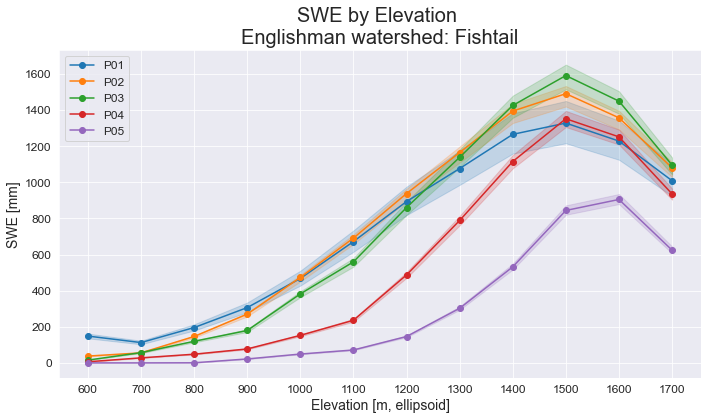

In [237]:
'''Use this script to take the zonal statistics table and graph the average sd w. stdev'''

import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker


sns.set_style("darkgrid")

#set parameters, will be added to function at later date
directory = r"H:\Englishman\2021\Analysis\swe_tables\processing\graphs"
parameter = "zbin"
wshed = "Englishman"
subbasin = "fishtail"
c_subbasin = "Fishtail"
file = parameter + "_" + subbasin + "_all.csv"
out_directory = r"H:\Englishman\2021\Analysis\figures\feb2- graphs_swe_test"
elevation_swe_title = "SWE by Elevation \n" + wshed + " watershed: " + c_subbasin
elevation_swe_output = "SWE_Elevation_" + wshed + "_" + c_subbasin + ".png"

os.chdir(directory)
df = pd.read_csv(file)

if subbasin == "cokely":
    df = df[df['zbin']>=900]
if subbasin == "fishtail":
    df = df[df['zbin']<=1700]

color_list = sns.color_palette()[:5]
print(color_list)


#set font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, ax = plt.subplots(figsize=(10,6))
fig.set_tight_layout(True)
#plt.subplots_adjust(top=.9,bottom=-.9)

p01 = df[df["Phase"]==1]
p02 = df[df["Phase"]==2]
p03 = df[df["Phase"]==3]
p04 = df[df["Phase"]==4]
p05 = df[df["Phase"]==5]

p1 = ax.plot(p01["zbin"], p01["swe_mm"], "-o", color=color_list[0])
p2 = ax.plot(p02["zbin"], p02["swe_mm"], "-o", color=color_list[1])
p3 = ax.plot(p03["zbin"], p03["swe_mm"], "-o", color=color_list[2])
p4 = ax.plot(p04["zbin"], p04["swe_mm"], "-o", color=color_list[3])
p5 = ax.plot(p05["zbin"], p05["swe_mm"], "-o", color=color_list[4])


ax.fill_between(p01["zbin"], p01["swe_lm"],p01["swe_hm"], alpha=0.2, color = color_list[0])
ax.fill_between(p02["zbin"], p02["swe_lm"],p02["swe_hm"], alpha=0.2, color = color_list[1])
ax.fill_between(p03["zbin"], p03["swe_lm"],p03["swe_hm"], alpha=0.2, color = color_list[2])
ax.fill_between(p04["zbin"], p04["swe_lm"],p04["swe_hm"], alpha=0.2, color = color_list[3])
ax.fill_between(p05["zbin"], p05["swe_lm"],p05["swe_hm"], alpha=0.2, color = color_list[4])

ax.set_xlabel('Elevation [m, ellipsoid]')
tick_spacing = 100
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax.yaxis.set_ticks(np.arange(0, 1700, 200))
ax.set_ylabel('SWE [mm]')
ax.legend([p1,p2,p3,p4,p5], labels=["P01", "P02", "P03", "P04", "P05"], loc="upper left", fontsize = "medium")
ax.set_title(elevation_swe_title, fontsize = 20)


os.chdir(out_directory)
plt.savefig(elevation_swe_output)
plt.show()

Week 4/5 : generate simple graphs, clean up code, back up to gihub